### 이미지 분류

#### CNN
- Convolutional Neural Network - 합성곱 신경망 : 이미지/영상으로부터 필터 개수와 같은 하이퍼파라미터를 조정하면서 특정추출하는 자동화 신경망 방법 중 하나

<!-- 이미지 복사/붙여넣기는 깃허브에서 오류
![cnn_concept.png](attachment:cnn_concept.png) -->
<img src="./cnn_concept.png" width="800">

- 참조 : https://mijeongban.medium.com/%EB%94%A5%EB%9F%AC%EB%8B%9D-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-cnn-convolutional-neural-networks-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0-836869f88375

In [56]:
import time
import os
import copy

import numpy as np

import matplotlib.pyplot as plt

## 파이토치
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

In [57]:
## CPU/GPU 확인
if torch.cuda.is_available():
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')

torch.__version__, device

('2.4.0+cu121', device(type='cuda'))

In [75]:
## CNN에서 제일 유명한 MNIST(미국 국립 표준기술연구소)에서 제공하는 이미지 데이터베이스
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [76]:
## 랜덤을 할 때마다 다른 결과가 나오기 때문에 랜덤 값을 고정할 필요 있음
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed(777)

In [77]:
## 하이퍼파라미터 지정
learning_rate = 0.001
training_epochs = 10
batch_size = 100 

In [78]:
## 파이토치 훈련, 테스트할 때 쉽게 쓸 수 있도록 데이터로더로 변환
train_ldr= DataLoader(dataset=train_ds, batch_size= 32, shuffle=True )
test_ldr= DataLoader(dataset=test_ds, batch_size= 32, shuffle=False ) ## Test(실험)데이터는 섞을 필요없음

In [79]:
len(train_ldr), len(test_ldr) # 8:2에 가까움 85:15

(1875, 313)

In [80]:
## 데이터 확인, X독립변수, y종속변수(답)
for(X_train, y_train) in train_ldr:
    print(f'X_train : {X_train.size()}, type:{X_train.type()} / y_train : {y_train.size()}, type : {y_train.type()}')
    break

X_train : torch.Size([32, 1, 28, 28]), type:torch.FloatTensor / y_train : torch.Size([32]), type : torch.LongTensor


In [81]:
## 배치사이즈 32 * 1875 = 60000장으로 구성
len(train_ldr), len(test_ldr)

(1875, 313)

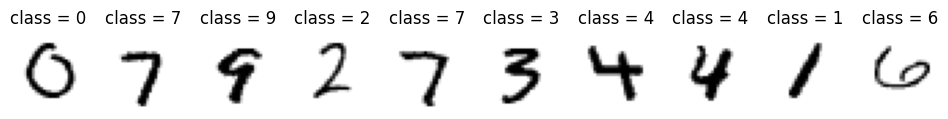

In [82]:
## 데이터셋 이미지 확인
plt.figure(figsize=(12,1))

for i in range(10):
    plt.subplot(1, 10, i+1) # 서브플롯을 10개 생성
    plt.axis('off')
    plt.imshow(X_train[i].numpy().reshape(28, 28), cmap='gray_r')
    plt.title(f'class = {y_train[i].item()}')

In [90]:
## 모델 생성
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째 히든레이어
        self.layer1 = nn.Sequential(
            ### nn.Conv2d(입력채널수, 출력채널수, 필터크기, kernel_size=연산수행 시 윈도우 크기 stride=필터를 적용하는 간격, padding=실제이미지 테두리에 빈 픽셀 추가)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), ## 활성화 함수는 ReLU 기본
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 두번째 히든레이어
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected layer 생성
        # 히든레이어를 하나 돌면 28/2 = 14x14 이미지, 두번째 히든레이어를 돌면 14/2 -> 7x7 이미지
        # 분류되는 결과값 0 ~ 9 때문에 마지막 레이어 출력 갯수 10개
        self.fc = nn.Linear(7 * 7 * 64, 10, bias=True)
        nn.init.xavier_uniform(self.fc.weight) # 가중치 정규분포 초기화(사비에르)

    ## 데이터셋이 레이어들을 통과할 수 있게
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # fc layer 보내기전에 배치사이즈 기준의 row만들고 나머지
        out = self.fc(out)
        return out

In [91]:
## CNN 모델 생성
model = CNN().to(device)

C:\Users\user\AppData\Local\Temp\ipykernel_18920\1264593660.py:22: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.fc.weight) # 가중치 정규분포 초기화(사비에르)


In [92]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [93]:
model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [94]:
## 손실함수, 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [95]:
total_batch = len(train_ldr) # 600
print('학습시작!')

for epoch in range(training_epochs):
    avg_cost = 0

    for X, y in train_ldr:
        # X 이미지 28*28
        X = X.to(device) # GPU 사용
        y = y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print(f'Epoch: {epoch+1:>4} cost = {avg_cost:>.9}')

print('훈련 끝!')

학습시작!
Epoch:    1 cost = 0.151819617
Epoch:    2 cost = 0.0482674651
Epoch:    3 cost = 0.0358683579
Epoch:    4 cost = 0.026888568
Epoch:    5 cost = 0.0210897867
Epoch:    6 cost = 0.0171798281
Epoch:    7 cost = 0.0127582885
Epoch:    8 cost = 0.0110740429
Epoch:    9 cost = 0.00908900332
Epoch:   10 cost = 0.00768490788
훈련 끝!


##### CPU/GPU 사용시 훈련시간
- CPU : 21분 29초
- GPU : 1분 24초
- GPU 썼을 때 CPU로 처리시간의 10배정도 효율

In [96]:
## 테스트 데이터로 실험
with torch.no_grad():
    X_test = test_ds.test_data.view(len(test_ds), 1, 28, 28).float().to(device=device)
    y_test = test_ds.test_labels.to(device=device)

    prediction = model(X_test)
    corrects = torch.argmax(prediction, 1) == y_test
    accuracy = corrects.float().mean()

    print(f'모델 정확도 = {accuracy.item()}')


c:\Sources\iot-bigdata-2024\gpu_env\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\Sources\iot-bigdata-2024\gpu_env\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


모델 정확도 = 0.9853999614715576


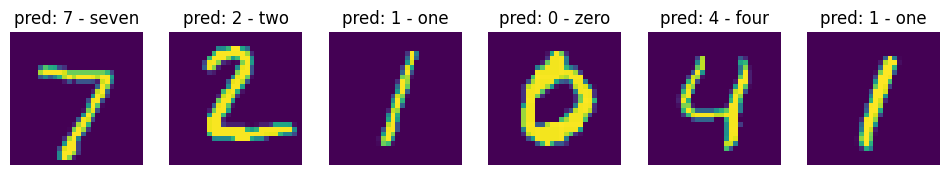

In [97]:
## 이미지 예측결과 확인
classes = train_ds.classes

def convert_format(image):
    image = image / 2 + 0.5
    image = image.numpy().clip(0.1)

    return image.transpose(1,2,0)

def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_ldr):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title('pred: {}'.format(classes[preds[j]]))
                ax.imshow( convert_format(images.cpu().data[j]) )

                if images_so_far == num_images:
                    return
                

visualize_model(model)